In [1]:
#Setting up competition libraries  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import riiideducation


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
#initializing libraries
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import gc

In [3]:
#Setting global variables 
random_seed = 0
train_ratio = 0.8
test_ratio = 1-train_ratio 
num_imp_str = 'median'

#training sample 
sample_size = 18000000 #18% of total

#LightGBM parameters
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': random_seed,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
         }

In [4]:
#loading training data
train = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',  
                       dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 'content_type_id': 'int8',
                              'task_container_id': 'int16', 'user_answer': 'int8', 'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                             'prior_question_had_explanation': 'boolean',
                             }
                      )
train = train.set_index('row_id')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 3.1 GB


In [5]:
#reading questions data
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
questions = questions.rename(columns = {'question_id':'content_id'})

In [6]:
#creating train-test split
def get_train_split(X, y):
    X_train , X_valid, y_train ,y_valid = train_test_split(X, y, train_size = train_ratio, 
                                                           test_size = test_ratio, random_state = random_seed)
    return(X_train, X_valid, y_train, y_valid)

In [7]:
#creating lgbm model and training 
def get_lgb(X_train, X_valid, y_train, y_valid):
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = None)
    lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature = None)
    
    #training
    model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8
    )
    return(model)

In [8]:
#missing data imputer
def impute_num(data ,impute_strategy):
    num_imputer = SimpleImputer(strategy=impute_strategy)
    data_imputed = pd.DataFrame(num_imputer.fit_transform(data))
    data_imputed.columns = data.columns
    data_imputed.index = data.index
    return(data_imputed)

In [9]:
#Preprocessing questions
#Process Tags
#Getting the tags out from the column

def process_tags(questions):
    
    tag = questions["tags"].str.split(" ", n = 6, expand = True) 
    tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
    
    #Conveting from string to numeric
    tag['tags1'] = pd.to_numeric(tag['tags1'], errors='coerce')
    tag['tags2'] = pd.to_numeric(tag['tags2'], errors='coerce')
    tag['tags3'] = pd.to_numeric(tag['tags3'], errors='coerce')
    tag['tags4'] = pd.to_numeric(tag['tags4'], errors='coerce')
    tag['tags5'] = pd.to_numeric(tag['tags5'], errors='coerce')
    tag['tags6'] = pd.to_numeric(tag['tags6'], errors='coerce')
    
    #imputing missing tag values 
    tag = tag.fillna(99999)
    
    drop_cols = ['tags','correct_answer']
    
    #Merging tags back to questions 
    questions = questions.drop(columns = drop_cols, axis = 1).join(tag)
    
    return questions

In [10]:
#Feature engineering
#adding user features
user_df = train[train.answered_correctly != -1].groupby('user_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
user_df.columns = ['user_id', 'user_questions', 'user_mean']

user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['watches_lecture'] = np.where(user_lect.Lecture > 0, 1, 0)
user_lect = user_lect.reset_index()
user_lect = user_lect[['user_id', 'watches_lecture']]

user_df = user_df.merge(user_lect, on = "user_id", how = "left")
del user_lect

In [11]:
#Feature engineering
#adding content features 
content_df = train[train.answered_correctly != -1].groupby('content_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
content_df.columns = ['content_id', 'content_questions', 'content_mean']

In [12]:
#Sampling from train data due to RAM limitation
#Preprocessing
train_sample = train.sample(n = sample_size, random_state = random_seed).copy()
del(train)
gc.collect()

40

In [13]:
#Cleaning up sampled data
train_sample.prior_question_had_explanation = train_sample.prior_question_had_explanation*1 #converting boolean to number
train_sample = train_sample.drop(train_sample[train_sample.answered_correctly == -1].index,axis = 0)  # removing lectures 
drop_cols = ['user_answer','content_type_id']
train_X = train_sample.drop(drop_cols, axis = 1)
del(train_sample)
gc.collect()

20

In [14]:
#Getting tag data 
questions_tag_pr = process_tags(questions)

In [15]:
#Merging train data and tag data
train_questions_X = train_X.merge(questions_tag_pr,on = 'content_id', how = 'left', suffixes = ('_left', '_right'))

del(train_X)
gc.collect()

20

In [16]:
#Imputing input data
y = train_questions_X.answered_correctly
drop_cols = ['answered_correctly']
train_questions_X = train_questions_X.drop(drop_cols, axis = 1)
train_imp = train_questions_X.copy()
train_imp.prior_question_elapsed_time = train_imp.prior_question_elapsed_time.fillna(0)
train_imp.prior_question_had_explanation = train_imp.prior_question_had_explanation.fillna(1)
train_imp = impute_num(train_imp ,num_imp_str)

#Creating train, valid set 
X_train, X_valid, y_train, y_valid = get_train_split(train_imp, y)
del(train_questions_X, train_imp)
gc.collect()

20

In [17]:
#Merging engineered features 

X_train = X_train.merge(user_df,on = 'user_id',how = 'left',suffixes=('_left', '_right'))
X_valid = X_valid.merge(user_df,on = 'user_id',how = 'left',suffixes=('_left', '_right'))
X_train = X_train.merge(content_df,on = 'content_id',how = 'left',suffixes=('_left', '_right'))
X_valid = X_valid.merge(content_df,on = 'content_id',how = 'left',suffixes=('_left', '_right'))

In [18]:
#Model
#LGBM
model = get_lgb(X_train, X_valid, y_train, y_valid)


Training until validation scores don't improve for 8 rounds
[50]	training's auc: 0.758216	valid_1's auc: 0.758239
[100]	training's auc: 0.759384	valid_1's auc: 0.759339
[150]	training's auc: 0.759812	valid_1's auc: 0.759703
[200]	training's auc: 0.760105	valid_1's auc: 0.759925
[250]	training's auc: 0.760324	valid_1's auc: 0.760079
[300]	training's auc: 0.760532	valid_1's auc: 0.760224
[350]	training's auc: 0.760705	valid_1's auc: 0.760328
[400]	training's auc: 0.760878	valid_1's auc: 0.760425
[450]	training's auc: 0.76105	valid_1's auc: 0.760521
[500]	training's auc: 0.761215	valid_1's auc: 0.760611
[550]	training's auc: 0.761367	valid_1's auc: 0.760692
[600]	training's auc: 0.761503	valid_1's auc: 0.760744
[650]	training's auc: 0.761643	valid_1's auc: 0.7608
[700]	training's auc: 0.761779	valid_1's auc: 0.760855
[750]	training's auc: 0.761905	valid_1's auc: 0.760904
[800]	training's auc: 0.762042	valid_1's auc: 0.760969
[850]	training's auc: 0.762183	valid_1's auc: 0.76103
[900]	trai

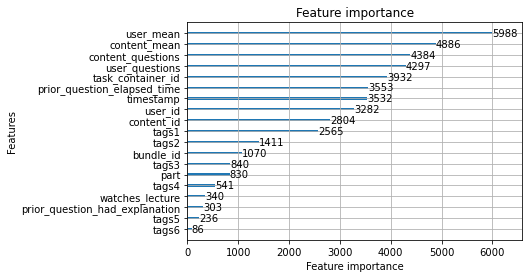

In [19]:
#Analyzing LGBM Model
#Feature importance
lgb.plot_importance(model)
plt.show()

In [20]:
#Initializing env variables
env = riiideducation.make_env()
iter_test = env.iter_test()

In [21]:
#Predictions on test data  

for (test_df, sample_prediction_df) in iter_test:
    
    test_df = test_df.set_index('row_id')
    test_copy = test_df.copy()
    
    test_copy = test_copy.drop(test_copy[test_copy.content_type_id == 1].index,axis = 0)
    drop_cols = ['prior_group_answers_correct','prior_group_responses','content_type_id']
    test_copy = test_copy.drop(columns = drop_cols,axis = 1)
    
    test_copy.prior_question_had_explanation = test_copy.prior_question_had_explanation*1 #converting boolian to number

    test_questions_X = test_copy.merge(questions_tag_pr,on = 'content_id', how = 'left', suffixes = ('_left', '_right'))
    
    test_copy_imp = test_questions_X.copy()
    test_copy_imp.prior_question_elapsed_time = test_copy_imp.prior_question_elapsed_time.fillna(0)
    test_copy_imp.prior_question_had_explanation = test_copy_imp.prior_question_had_explanation.fillna(1)


    test_copy_imp = impute_num(test_copy_imp ,num_imp_str)

    test_copy_imp = test_copy_imp.merge(user_df,on = 'user_id',how = 'left',suffixes=('_left', '_right'))
    test_copy_imp = test_copy_imp.merge(content_df,on = 'content_id',how = 'left',suffixes=('_left', '_right'))
    
    pred = model.predict(test_copy_imp)
    
    df = pd.DataFrame({'row_id': test_copy.index, 'answered_correctly': pred})
    df = df.set_index('row_id')
    test_df = test_df.join(df)
    test_df.answered_correctly.fillna(-1, inplace = True)
    
    
    test_df = test_df.reset_index()
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])